In [8]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import warnings
warnings.filterwarnings('ignore')

In [163]:
import gsd,gsd.hoomd
import gsd.pygsd
import seaborn as sns
import statistics as stat
from scipy import stats
from scipy.interpolate import interp1d

In this example we will run a coarse-grained (CG) simulation for a 2 bead methanol system with 1000 CG molecules

In [12]:
aa_rdf = np.load('CG_tutorial/aa_rdf.npy')
cg_rdf = np.load('CG_tutorial/cg_rdf.npy')

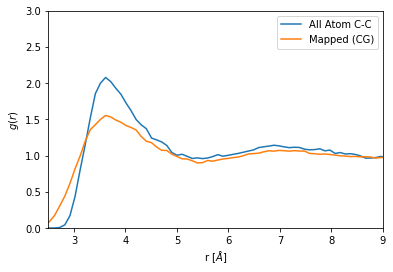

In [20]:
r = aa_rdf[1,:]
plt.plot(aa_rdf[1,:], aa_rdf[0,:] / aa_rdf[0,-1],label ='All Atom C-C')
plt.plot(cg_rdf[1,:], cg_rdf[0,:] / cg_rdf[0,-1], label='Mapped (CG)')
plt.xlim(2.5,9)
plt.ylim(0,3)
plt.xlabel(r'r [$\AA$]')
plt.ylabel('$g(r)$')
plt.legend()
plt.show()

In [131]:
with gsd.hoomd.open('CG_tutorial/meth_traj.gsd', 'rb') as t:
    cg_pos=[]
    for i in range(len(t)):
        cg_pos.append(t[i].particles.position)

cg_pos = np.asarray(cg_pos)
print(cg_pos.shape)

250
(250, 6000, 3)


In [136]:
print(cg_pos[:,7].shape)

(250, 3)


In [143]:
total_cg = []
for mol in range(250):
    cg_positions=[]
    for i in range(0,1000):
        c = i*6
        o = 1 + i*6
        b1 = cg_pos[mol][c]
        b2 = cg_pos[mol][o]
        cg_positions.append(b1)
        cg_positions.append(b2)
    total_cg.append(cg_positions)
    
np.save('CG_tutorial/meth_CGtraj_positions.npy',total_cg)

In [146]:
adjacency_matrix = np.array([[0,1],[1,0]])

bonds,angs,dihes = htf.compute_cg_graph(DSGPM=False,adj_mat=adjacency_matrix,group_atoms=False) #Use compute_cg_graph

bond_ids,ang_ids,dihe_ids = htf.mol_features_multiple(bonds,molecules=1000,beads=2)


CG coordinates are not caculated. Only connectivities are calculated


In [155]:
box=np.array([[-20.4471, -20.4471, -20.4471],[20.4471, 20.4471, 20.4471],[0, 0, 0]],dtype=np.float32)
cg_positions = np.load('CG_tutorial/meth_CGtraj_positions.npy')
bond_distribution = []
for frame in range(cg_positions.shape[0]):
    cg_r = []
    for i in range(len(bond_ids)):
        cg_dist = htf.mol_bond_distance(CG = True, cg_positions = cg_positions[frame],
                                     b1=bond_ids[i][0],b2=bond_ids[i][1],box=box)
        cg_r.append(cg_dist)
        
    bond_distribution.append(cg_r)
    
bond_distribution= np.array(bond_distribution)

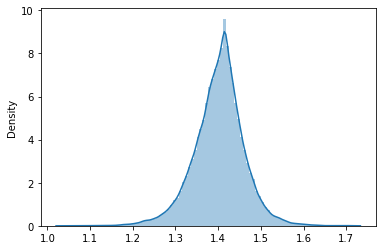

In [161]:
rdata = bond_distribution.reshape((-1))
dist_kde = sns.distplot(rdata,bins=100,kde=True)

In [162]:
print(min(rdata),max(rdata))

1.0349673 1.7184982


In [194]:
rdata = np.sort(rdata)
r_var = np.var(rdata)
r0 = stat.mean(rdata)
kr = (kb*T/r_var) 
print(r0,kr)

1.40191 171.71954922166913


In [166]:
kb = 1.9872/1000
T = 300.
gr = cg_rdf[0,:]/np.mean(gr[-10:])
r = cg_rdf[1,:]
#ugr = -T*kb*np.log(gr)
#fgr = -np.gradient(ugr,0.01)

In [169]:
smooth = interp1d(r,gr,kind='cubic',fill_value = "extrapolate")
r_smooth = np.arange(1.0,1.8,0.001)
gr_smooth = smooth(r_smooth)
pair_pot = -T*kb*np.log(gr_smooth)
pair_force = -np.gradient(pair_pot,0.001)


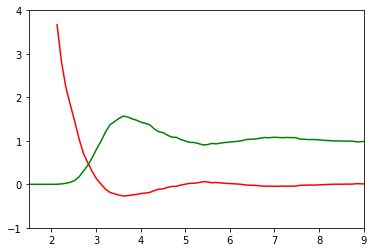

In [167]:
plt.plot(r,ugr,color='r',label='U(pair)')
plt.plot(r,gr,color='g',label='gr')
plt.xlim(1.5,9)
plt.ylim(-1,4)
plt.show()

In [197]:
col_format = "{0:5.3f}"+"{1:10.4f}"+"{2:10.4f}" + '\n'

with open('CG_tutorial/BI_pair_potential.dat','w') as outfile:
    for items in zip(r_smooth,pair_pot*10,pair_force):
        outfile.write(col_format.format(*items))

# Part 2: running CG simulation

In [208]:
hoomd.context.initialize('')
s = hoomd.data.make_snapshot(N=2000,box= hoomd.data.boxdim(L=1000),particle_types=['CG'],
                              bond_types=['B1'])
s.particles.position[:] = np.load('CG_tutorial/meth_CGtraj_positions.npy')[0]
s.particles.typeid[:] = 0
s.bonds.resize(bond_ids.shape[0])
s.bonds.group[:] = bond_ids
c = hoomd.context.initialize('--gpu=1')
system = hoomd.init.read_snapshot(s)
set_rcut = 10.0
#/ Set system potentials
nlist = hoomd.md.nlist.cell()
nlist.reset_exclusions(['bond', 'angle','dihedral'])
bharm = hoomd.md.bond.harmonic(name='bonds')
bharm.bond_coeff.set('B1',k=170.0,r0=1.4)
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nlist)
lj.pair_coeff.set('CG', 'CG', epsilon=1.0, sigma=1.0)
#pairtable = hoomd.md.pair.table(width=800, nlist=nlist)
#pairtable.set_from_file('CG','CG',filename='CG_tutorial/BI_pair_potential.dat')

*Warning*: Ignoring new options, cannot change execution mode after initialization.


notice(2): Group "all" created containing 2000 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no


NameError: name 'nl' is not defined

In [206]:
#==========================================
group_all = hoomd.group.all()
kT = 1.9872/1000

timestep = 10/489.9
im = hoomd.md.integrate.mode_standard(dt=timestep)
nve = hoomd.md.integrate.nve(group=group_all)
nve.randomize_velocities(seed=1234,kT=298.15 * kT)
hoomd.run(1000)
#equilibrate
#hoomd.analyze.log(filename=file+'.log',quantities = ['potential_energy', 'kinetic_energy'],
#                  period=10,overwrite=True,header_prefix='#')

#hoomd.run(nstep)


** starting run **


**ERROR**: out of memory before /hoomd/GPUArray.h:947


RuntimeError: CUDA Error